In [17]:
import pandas as pd
import geopandas
import numpy as np


from scipy.spatial import cKDTree
from shapely.geometry import Point

<AxesSubplot:>

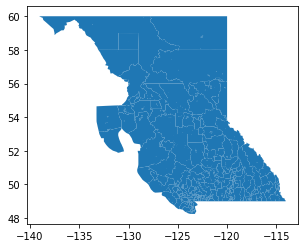

In [18]:
census_boundaries = geopandas.read_file("raw/lcsd000a16a_e.shp")
census_boundaries_bc = census_boundaries[census_boundaries["PRUID"] == "59"]
census_boundaries_bc = census_boundaries_bc.to_crs(epsg=4326)
census_boundaries_bc.plot()

<AxesSubplot:>

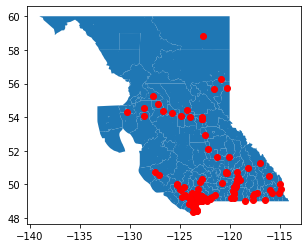

In [19]:
school_report = pd.read_csv("combined_school_report.csv")
school_representative = school_report.groupby("SCHOOL_NUMBER").first().reset_index()
school_gdf = geopandas.GeoDataFrame(school_representative, geometry=geopandas.points_from_xy(school_representative.SCHOOL_LONGITUDE, school_representative.SCHOOL_LATITUDE))
school_gdf = school_gdf.set_crs(epsg=4326)
school_gdf.plot(ax=census_boundaries_bc.plot(), marker='o', color='red')

In [20]:
# Taken from https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.centroid.x, x.centroid.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

mapped = ckdnearest(census_boundaries_bc, school_gdf)
csduid_to_school = mapped[["CSDUID", "SCHOOL_NUMBER"]]
csduid_to_school.groupby("SCHOOL_NUMBER").count().reset_index()

,SCHOOL_NUMBER,CSDUID
0,502001,5
1,505033,1
2,505034,3
3,505035,2
4,603008,2
...,...,...
127,8585026,14
128,9156002,21
129,9156007,9
130,9191023,19


This seems to discard a whole bunch of schools. Another approach is to only assign the census subdivison, which in BC is an administrative subdivision like a municipality, that the school is in. This is inconsistent with how we assigned the speed markers, but this ensures that every school gets some income data.

In [21]:
school_gdf_with_cd = school_gdf
school_gdf_with_cd["CENSUS_ID"] = ""

for index, school in school_gdf_with_cd.iterrows():
    for i, census_sub in census_boundaries_bc.iterrows():
        if school.geometry.within(census_sub.geometry):
            school_gdf_with_cd.loc[index, "CENSUS_ID"] = census_sub["CSDUID"]

In [22]:
counts = school_gdf_with_cd.groupby("CENSUS_ID").size().reset_index(name="counts_school")
counts[counts["counts_school"] > 1]

,CENSUS_ID,counts_school
15,5907041,2
17,5909020,3
19,5909052,8
21,5915001,8
22,5915004,25
23,5915011,8
24,5915015,11
26,5915022,25
27,5915025,9
29,5915034,3


As we can see some districts are oversubscribed. This has to do with the initial school data: since it's only for the top 250 schools, it's likely these are somewhat concentrated in urban, affluent areas so many schools end up in the same census subdivision. While unfortunate, this is not catastrophic: it still reflects the income level of the school, although it is now incongrous with the bandwidth availability.  

In [37]:
income_data = pd.read_csv("raw/income_2016_census.csv")
income_data_subdivision = income_data[income_data["GEO_LEVEL"] == 3]
income_data_subdivision = income_data_subdivision[income_data_subdivision["Member ID: Household type including census family structure (11)"] == 1]
school_gdf_with_cd = school_gdf_with_cd.astype(dtype={"CENSUS_ID": "int64"})
school_income_mapping = school_gdf_with_cd[["SCHOOL_NUMBER", "CENSUS_ID"]].merge(income_data_subdivision[["GEO_CODE (POR)", "Dim: Household income statistics (3): Member ID: [2]: Median total income of households ($)"]], left_on="CENSUS_ID", right_on="GEO_CODE (POR)")
school_income_mapping = school_income_mapping.drop("GEO_CODE (POR)", axis=1)
school_income_mapping = school_income_mapping.rename(columns={"Dim: Household income statistics (3): Member ID: [2]: Median total income of households ($)": "MEDIAN_INCOME"})
school_income_mapping

,SCHOOL_NUMBER,CENSUS_ID,MEDIAN_INCOME
0,502001,5901022,67942
1,505033,5901003,110379
2,505034,5901012,90112
3,505035,5901006,103538
4,603008,5901028,67072
...,...,...,...
230,8585026,5943023,56277
231,9156002,5951009,75776
232,9156007,5951013,80896
233,9191023,5951022,68267
